# Example of Image Subtraction on NIRCam observations with B-Spline SFFT 

Author: Lei Hu <leihu@andrew.cmu.edu>  
Last Verified to run: 2024-02-01  
Reference: https://arxiv.org/abs/2309.09143

Use the [SFFT](https://github.com/thomasvrussell/sfft) package to perform image differencing for NIRCam observations of Abell 2744.

### Notable Requirements:  
sfft (>= 1.5.0), cupy, astropy, scipy, numpy, matplotlib   
SourceExtractor

### Test Data
Reference Image: Abell 2744 NIRCam/F200W, taken in Jun, 2022, from GLASS program JWST-ERS-1324   
Science Image:   Abell 2744 NIRCam/F200W, taken in Nov, 2022, from UNCOVER program JWST-GO-2561   

### Remarks
  * [ ] The current example is used to demonstrate how B-Spline SFFT works on the NIRCam observations.
  * [ ] A more complete transient pipeline tailored for JWST NIRCam/NIRISS time-domain analysis is being developed with more improvements to be incorporated.
  * [ ] The transient pipeline is based on B-Spline SFFT will become open-source soon, as a part of the JWST Cycle 3 Archival Program [AR 5965](https://www.stsci.edu/jwst/science-execution/program-information?id=5965).

#### Setup directory paths

In [1]:
__author__ = "Lei Hu <hulei@andrew.cmu.edu>"
__publication__ = "https://arxiv.org/abs/2309.09143"

MAINDIR = pa.dirname(pa.abspath(__file__))
input_dir = MAINDIR + '/input_data'
output_dir = MAINDIR + '/output_data'
aux_dir = MAINDIR + '/auxiliary'

# setup reference & science filename
refname = 'jw01324001001-01324-o001_t001_nircam_clear-f200w_i2d_stamp' # A2744 (F200W) on Jun, 2022 from JWST-ERS-1324
sciname = 'jw02561001002-02561-o001_t003_nircam_clear-f200w_i2d_stamp' # A2744 (F200W) on Nov, 2022 from JWST-GO-2561

### Step1. perform cross convolution for coarse psf aligmentment 
#### Note: Cross convolution means REF $\circ$ PSF_SCI and SCI $\circ$ PSF_REF, see Eq. 20 in the paper.

In [2]:
import numpy as np
import os.path as pa
from astropy.io import fits
from astropy.convolution import convolve_fft

FITS_lREF = input_dir + '/%s.fits' %refname  # reference (not conovlved)
FITS_lSCI = input_dir + '/%s.fits' %sciname  # science   (not conovlved)

FITS_PSF_lREF = aux_dir + '/%s.WebbPSF.fits' %refname  # WebbPSF model for reference
FITS_PSF_lSCI = aux_dir + '/%s.WebbPSF.fits' %sciname  # WebbPSF model for science

# read reference and science and their psf
PixA_lREF = fits.getdata(FITS_lREF, ext=0).T
PixA_lSCI = fits.getdata(FITS_lSCI, ext=0).T

PixA_PSF_lREF = fits.getdata(FITS_PSF_lREF, ext=0).T
PixA_PSF_lSCI = fits.getdata(FITS_PSF_lSCI, ext=0).T

# convolve science psf on reference
PixA_lREF_convd = convolve_fft(PixA_lREF, PixA_PSF_lSCI, boundary='fill', \
    nan_treatment='fill', fill_value=0.0, normalize_kernel=True)
FITS_lREF_convd = output_dir + '/%s.crossConvd.fits' %refname

with fits.open(FITS_lREF) as hdl:
    _message = 'Convolving image ... \n # %s' %FITS_lREF_convd
    print('\nMeLOn CheckPoint: %s!' %_message)
    hdl[0].data[:, :] = PixA_lREF_convd.T
    hdl.writeto(FITS_lREF_convd, overwrite=True)

# convolve reference psf on science
PixA_lSCI_convd = convolve_fft(PixA_lSCI, PixA_PSF_lREF, boundary='fill', \
    nan_treatment='fill', fill_value=0.0, normalize_kernel=True)

FITS_lSCI_convd = output_dir + '/%s.crossConvd.fits' %sciname
with fits.open(FITS_lSCI) as hdl:
    _message = 'Convolving image ... \n # %s' %FITS_lSCI_convd
    print('\nMeLOn CheckPoint: %s!' %_message)
    hdl[0].data[:, :] = PixA_lSCI_convd.T
    hdl.writeto(FITS_lSCI_convd, overwrite=True)
        


MeLOn CheckPoint: Convolving image ... 
 # /hildafs/projects/phy220048p/leihu/AstroWork/JWSFFT/Revision/pack/test/output_data/jw01324001001-01324-o001_t001_nircam_clear-f200w_i2d_stamp.crossConvd.fits!

MeLOn CheckPoint: Convolving image ... 
 # /hildafs/projects/phy220048p/leihu/AstroWork/JWSFFT/Revision/pack/test/output_data/jw02561001002-02561-o001_t003_nircam_clear-f200w_i2d_stamp.crossConvd.fits!


### Step2. perform B-spline SFFT subtraction for more accurate image matching (see Eq. 21 in the paper).

In [3]:
import sys
from sfft.BSplineSFFT import BSpline_Packet

FITS_REF = FITS_lREF_convd  # reference (convolved)
FITS_SCI = FITS_lSCI_convd  # science (convolved)

# read image mask for sfft 
FITS_SUBTMASK = aux_dir + '/%s.mask4sfft.fits' %sciname  # shared image mask for solving sfft
SUBTMASK = fits.getdata(FITS_SUBTMASK, ext=0).T.astype(bool)

# generate masked images
FITS_mREF = FITS_REF[:-5] + '.masked.fits'
with fits.open(FITS_REF) as hdl:
    _message = 'Mask image for sfft ... \n # %s' %FITS_mREF
    print('\nMeLOn CheckPoint: %s!' %_message)
    _PixA = hdl[0].data.T
    _PixA[~SUBTMASK] = 0.0  # zero-mask
    hdl[0].data[:, :] = _PixA.T
    hdl.writeto(FITS_mREF, overwrite=True)

FITS_mSCI = FITS_SCI[:-5] + '.masked.fits'
with fits.open(FITS_SCI) as hdl:
    _message = 'Mask image for sfft ... \n # %s' %FITS_mSCI
    print('\nMeLOn CheckPoint: %s!' %_message)
    _PixA = hdl[0].data.T
    _PixA[~SUBTMASK] = 0.0  # zero-mask
    hdl[0].data[:, :] = _PixA.T
    hdl.writeto(FITS_mSCI, overwrite=True)



MeLOn CheckPoint: Mask image for sfft ... 
 # /hildafs/projects/phy220048p/leihu/AstroWork/JWSFFT/Revision/pack/test/output_data/jw01324001001-01324-o001_t001_nircam_clear-f200w_i2d_stamp.crossConvd.masked.fits!

MeLOn CheckPoint: Mask image for sfft ... 
 # /hildafs/projects/phy220048p/leihu/AstroWork/JWSFFT/Revision/pack/test/output_data/jw02561001002-02561-o001_t003_nircam_clear-f200w_i2d_stamp.crossConvd.masked.fits!


In [4]:
# >>>> configure B-Spline sfft subtraction <<<< #
N0, N1 = SUBTMASK.shape
ForceConv = 'REF'             # convolve 'REF' or 'SCI'

# a. Set HalfWidth of Matching Kernel 
GKerHW = 11                   # for short-wave channel
#GKerHW = 5                   # for long-wave channel

# b. Set Spatial Variation for Kernel
#    P.S. for long-wave channel:
#    one can tune the internal knots to make a gird of 150 x 150 pix
KerSpType = 'B-Spline'                    # B-Spline form
KerSpDegree = 2                           # degree
KerIntKnotX = [0.5+N0*1/3, 0.5+N0*2/3]    # internal knots along x, using a grid of 300 x 300 pix
KerIntKnotY = [0.5+N1*1/3, 0.5+N1*2/3]    # internal knots along y, using a grid of 300 x 300 pix 

# c. Set Spatial Varaition for Photometric Scaling 
SEPARATE_SCALING = True       # Disentagled from Kernel Spatial Varaition
ScaSpType = 'Polynomial'      # Polynomial form 
ScaSpDegree = 2               # degree
ScaIntKnotX = []              # trivial 
ScaIntKnotY = []              # trivial

# d. Set Spatial Varaition for Differential Background
#    assume background sutraction has been well performed, using a trivial setting 
BkgSpType = "Polynomial"
BkgSpDegree = 0
BkgIntKnotX = []
BkgIntKnotY = []

# e. Set Parameters for Tikhonov regularization
REGULARIZE_KERNEL = True            # active Tikhonov regularization?
IGNORE_LAPLACIAN_KERCENT = True     # do not suppress delta-like kernel?
np.random.seed(10086)
XY_REGULARIZE = np.array([
    np.random.uniform(10., N0-10., 512),
    np.random.uniform(10., N1-10., 512)
]).T                  # random image coordinates for regularization
LAMBDA_REGULARIZE = 3*1e-5         # regularization strength factor


In [5]:
FITS_DIFF = FITS_SCI[:-5] + '.sfftdiff.fits'            # difference (not decorrelated)
FITS_Solution = FITS_SCI[:-5] + '.sfftsolution.fits'    # solution for sfft image matching

# P.S. this step takes ~ 2.6s in Tesla A100 GPU.
#      note that the first round can be very slow as some GPU initilization, 
#      if we run a loop over a set of images, the time will be back to ~ 2.6s from the second file
#      (try to re-run the cell and you will notice the time reduce) 

MAX_THREADS_PER_BLOCK = 7   # decrease to 4 if you get an error that your GPU device does not have enough shared memory
PixA_DIFF = BSpline_Packet.BSP(FITS_REF=FITS_REF, FITS_SCI=FITS_SCI, FITS_mREF=FITS_mREF, FITS_mSCI=FITS_mSCI, \
    FITS_DIFF=FITS_DIFF, FITS_Solution=FITS_Solution, ForceConv=ForceConv, GKerHW=GKerHW, \
    KerSpType=KerSpType, KerSpDegree=KerSpDegree, KerIntKnotX=KerIntKnotX, KerIntKnotY=KerIntKnotY, \
    SEPARATE_SCALING=SEPARATE_SCALING, ScaSpType=ScaSpType, ScaSpDegree=ScaSpDegree, \
    ScaIntKnotX=ScaIntKnotX, ScaIntKnotY=ScaIntKnotY, BkgSpType=BkgSpType, \
    BkgSpDegree=BkgSpDegree, BkgIntKnotX=BkgIntKnotX, BkgIntKnotY=BkgIntKnotY,\
    REGULARIZE_KERNEL=REGULARIZE_KERNEL, IGNORE_LAPLACIAN_KERCENT=IGNORE_LAPLACIAN_KERCENT, \
    XY_REGULARIZE=XY_REGULARIZE, WEIGHT_REGULARIZE=None, LAMBDA_REGULARIZE=LAMBDA_REGULARIZE, \
    BACKEND_4SUBTRACT='Cupy', CUDA_DEVICE_4SUBTRACT='0', MAX_THREADS_PER_BLOCK=MAX_THREADS_PER_BLOCK, \
    MINIMIZE_GPU_MEMORY_USAGE=True, VERBOSE_LEVEL=1)[1]


MeLOn CheckPoint: TRIGGER Function Compilations of SFFT-SUBTRACTION!

 --//--//--//--//-- TRIGGER SFFT COMPILATION [Cupy] --//--//--//--//-- 

 ---//--- B-Spline Kernel | Internal Knots 2,2 | KerSpDegree 2 | KerHW 11 ---//---

 ---//--- [SEPARATE] Polynomial Scaling | ScaSpDegree 2 ---//---

 ---//--- Polynomial Background | BkgSpDegree 0 ---//---

 --//--//--//--//-- EXIT SFFT COMPILATION --//--//--//--//-- 

MeLOn Report: FUNCTION COMPILATIONS OF SFFT-SUBTRACTION TAKES [0.000 s] 

MeLOn CheckPoint: TRIGGER SFFT-SUBTRACTION!

 --//--//--//--//-- TRIGGER SFFT SUBTRACTION [Cupy] --//--//--//--//-- 

 ---//--- B-Spline Kernel | Internal Knots 2,2 | KerSpDegree 2 | KerHW 11 ---//---

 ---//--- [SEPARATE] Polynomial Scaling | ScaSpDegree 2 ---//---

 ---//--- Polynomial Background | BkgSpDegree 0 ---//---

MeLOn CheckPoint: SFFT-SUBTRACTION Preliminary Steps takes [0.7002s]

MeLOn CheckPoint: SFFT-SUBTRACTION Establish & Solve Linear System takes [4.0714s]

 --||--||--||--||-- EXIT SFFT SU

#### Step3. perform noise decorrelation on difference (see Eq. 22 in the paper)
##### Note: here noise decorrelation is performed tile-by-tile to take account spatial variation of matching kernels

In [6]:
from sfft.BSplineSFFT import BSpline_MatchingKernel, BSpline_DeCorrelation, BSpline_GridConvolve
from sfft.utils.SkyLevelEstimator import SkyLevel_Estimator
from sfft.utils.meta.MultiProc import Multi_Proc

# define an image grid for tile-by-tile decorrelation
TILESIZE_RATIO = 5   # FIXME, one can also use finer value like 1
_hdr = fits.getheader(FITS_lSCI, ext=0)
N0, N1 = int(_hdr['NAXIS1']), int(_hdr['NAXIS2'])

lab = 0
XY_TiC = []
TiHW = round(TILESIZE_RATIO * GKerHW)
TiN = 2*TiHW+1

AllocatedL = np.zeros((N0, N1), dtype=int)
for xs in np.arange(0, N0, TiN):
    xe = np.min([xs+TiN, N0])
    for ys in np.arange(0, N1, TiN):
        ye = np.min([ys+TiN, N1])
        AllocatedL[xs: xe, ys: ye] = lab
        x_q = 0.5 + xs + (xe - xs)/2.0   # tile-center (x)
        y_q = 0.5 + ys + (ye - ys)/2.0   # tile-center (y)
        XY_TiC.append([x_q, y_q])
        lab += 1
XY_TiC = np.array(XY_TiC)
NTILE = XY_TiC.shape[0]
print('MeLOn CheckPoint: [%d] DeCorrelation Tiles of size [%d x %d]' %(NTILE, TiN, TiN))


MeLOn CheckPoint: [81] DeCorrelation Tiles of size [111 x 111]


In [7]:
NPROC = 32  # FIXME, number of multi-threads

# read the matching kernels over the grid
MKerStack = BSpline_MatchingKernel(XY_q=XY_TiC).FromFITS(FITS_Solution=FITS_Solution)
MKerFStack = np.array([np.append([XY_TiC[i, 0], XY_TiC[i, 1]], MKerStack[i].flatten()) 
    for i in range(NTILE)])   # NOTE: each row is x, y + flatten matching kernel

# read WebbPSF models
PixA_PSF_lREF = fits.getdata(FITS_PSF_lREF, ext=0).T
PixA_PSF_lSCI = fits.getdata(FITS_PSF_lSCI, ext=0).T

# measure background noise for unconvolved reference and science
bkgsig_lREF = SkyLevel_Estimator.SLE(PixA_obj=fits.getdata(FITS_lREF, ext=0).T)[1]
bkgsig_lSCI = SkyLevel_Estimator.SLE(PixA_obj=fits.getdata(FITS_lSCI, ext=0).T)[1]

# define the function for calculating noise decorrelation kernels
def func_decorr(idx):
    MKer = MKerStack[idx]
    DCKer = BSpline_DeCorrelation.BDC(MK_JLst=[PixA_PSF_lREF], SkySig_JLst=[bkgsig_lSCI], \
        MK_ILst=[PixA_PSF_lSCI], SkySig_ILst=[bkgsig_lREF], MK_Fin=MKer, \
        KERatio=2.0, DENO_CLIP_RATIO=100000.0, VERBOSE_LEVEL=0)
    return DCKer

# run the function in parallel 
taskid_lst = np.arange(NTILE)
MPDICT = Multi_Proc.MP(taskid_lst=taskid_lst, func=func_decorr, nproc=NPROC, mode='mp')

DCKerStack = np.array([MPDICT[idx] for idx in taskid_lst])
DCKerFStack = np.array([np.append([XY_TiC[i, 0], XY_TiC[i, 1]], DCKerStack[i].flatten()) 
    for i in range(NTILE)])   # NOTE: each row is x, y + flatten decorrelation kernel



 --//--//--//--//-- SFFT CONFIGURATION --//--//--//--//-- 

 ---//--- B-Spline Kernel | Internal Knots 2,2 | KerSpDegree 2 | KerHW 11 ---//---

 ---//--- [SEPARATE] Polynomial Scaling | ScaSpDegree 2 ---//---


In [8]:
# zero-out boundary before decorrelation
BoundaryMask = np.ones((N0, N1)).astype(bool)
BoundaryMask[GKerHW:-GKerHW, GKerHW:-GKerHW] = False

# perform decorrlation for DIFF on the grid, mask boundary
PixA_obj = PixA_DIFF.copy()
PixA_obj[BoundaryMask] = 0.
_GSVC = BSpline_GridConvolve(PixA_obj=PixA_DIFF, AllocatedL=AllocatedL, KerStack=DCKerStack, 
    nan_fill_value=0.0, use_fft=True, normalize_kernel=True)
PixA_DCDIFF = _GSVC.GSVC_GPU(CUDA_DEVICE='0', CLEAN_GPU_MEMORY=True, nproc=NPROC)
PixA_DCDIFF[BoundaryMask] = 0.

FITS_DCDIFF = FITS_DIFF[:-5] + '.DeCorrelated.fits'
with fits.open(FITS_DIFF) as hdl:
    hdl[0].data[:, :] = PixA_DCDIFF.T
    hdl.writeto(FITS_DCDIFF, overwrite=True)
print('MeLOn CheckPoint: DeCorrelated DIFF Saved! \n # %s!' %FITS_DCDIFF)


MeLOn CheckPoint: DeCorrelated DIFF Saved! 
 # /hildafs/projects/phy220048p/leihu/AstroWork/JWSFFT/Revision/pack/test/output_data/jw02561001002-02561-o001_t003_nircam_clear-f200w_i2d_stamp.crossConvd.sfftdiff.DeCorrelated.fits!


#### Step4. divide propagrated noise to get differential SNR map (see Eq. 24 in the paper)

In [9]:
# function to calculate propagated Noise Map that went through Convolution(s) using a Monte Carlo approach
def MultiConvolveNoise(PixA_Noise, ConvKerSeq, KerNormalizeSeq, \
    MCNSAMP=1024, RANDOM_SEED=10086, NPROC=32):
                       
    def func_multiconv(idx):
        np.random.seed(RANDOM_SEED+idx)
        PixA_SampledNoise = np.random.normal(0, 1, PixA_Noise.shape) * PixA_Noise
        PixA_CSampledNoise = PixA_SampledNoise.copy()
        for ConvKer, KerNormalize in zip(ConvKerSeq, KerNormalizeSeq):
            PixA_CSampledNoise = convolve_fft(PixA_CSampledNoise, ConvKer, boundary='fill', \
                nan_treatment='fill', fill_value=0.0, normalize_kernel=KerNormalize)
        return PixA_CSampledNoise
    
    Ntask = MCNSAMP
    taskid_lst = np.arange(Ntask)
    MPDICT = Multi_Proc.MP(taskid_lst=taskid_lst, func=func_multiconv, nproc=NPROC, mode='mp')
    SPixA_CSampledNoise = np.array([MPDICT[idx] for idx in taskid_lst])
    return SPixA_CSampledNoise

# read noise map for uncovolved reference and science
FITS_lREF_Noise = aux_dir + '/%s.noise.fits' %refname  # reference noise (not conovlved)
FITS_lSCI_Noise = aux_dir + '/%s.noise.fits' %sciname  # science noise  (not conovlved)
PixA_lREF_Noise = fits.getdata(FITS_lREF_Noise, ext=0).T
PixA_lSCI_Noise = fits.getdata(FITS_lSCI_Noise, ext=0).T

# calculate mean DeCorrelation Kernel (approximation here)
_L = round(np.sqrt(DCKerFStack.shape[1]-2))
PixA_DCKerMean = np.mean(DCKerFStack[:, 2:], axis=0).reshape((_L, _L))

# calculate mean Matching Kernel (approximation here)
_L = 2*GKerHW+1
PixA_MKerMean = np.mean(MKerFStack[:, 2:], axis=0).reshape((_L, _L))

# set the number of sampling for MC
MCNSAMP = 32   # FIXME, one can increase this

# noise propagration for the science side
PixA_Noise = PixA_lSCI_Noise
ConvKerSeq, KerNormalizeSeq = [PixA_PSF_lREF, PixA_DCKerMean], [True, True]
SPixA_NoiseS = MultiConvolveNoise(PixA_Noise, ConvKerSeq, KerNormalizeSeq, \
    MCNSAMP=MCNSAMP, RANDOM_SEED=10086, NPROC=NPROC)

# noise propagration for the science side
PixA_Noise = PixA_lREF_Noise
ConvKerSeq, KerNormalizeSeq = [PixA_PSF_lSCI, PixA_MKerMean, PixA_DCKerMean], [True, False, True]
SPixA_NoiseR = MultiConvolveNoise(PixA_Noise, ConvKerSeq, KerNormalizeSeq, \
    MCNSAMP=MCNSAMP, RANDOM_SEED=2*10086, NPROC=NPROC)   # avoid to use overlapping seed

# noise propagration for decorrelated difference
SPixA_NoiseD = SPixA_NoiseS - SPixA_NoiseR
PixA_NoiseD = np.std(SPixA_NoiseD, axis=0)

# divive decorrelated difference by the propagated noise 
PixA_DCDIFF_SNR = PixA_DCDIFF / PixA_NoiseD

FITS_DCDIFF_SNR = FITS_DCDIFF[:-5] + '.SNR.fits'
with fits.open(FITS_DCDIFF) as hdl:
    hdl[0].data[:, :] = PixA_DCDIFF_SNR.T
    hdl.writeto(FITS_DCDIFF_SNR, overwrite=True)
print('MeLOn CheckPoint: SNR Map of DeCorrelated DIFF Saved! \n # %s!' %FITS_DCDIFF_SNR)


MeLOn CheckPoint: SNR Map of DeCorrelated DIFF Saved! 
 # /hildafs/projects/phy220048p/leihu/AstroWork/JWSFFT/Revision/pack/test/output_data/jw02561001002-02561-o001_t003_nircam_clear-f200w_i2d_stamp.crossConvd.sfftdiff.DeCorrelated.SNR.fits!


#### Step5. Check subtraction performance

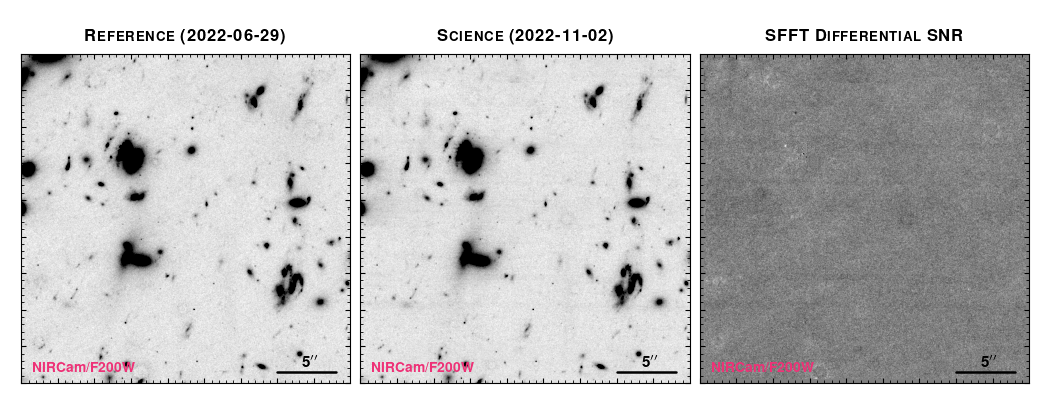

In [10]:
import warnings
import scipy.stats as stats
from scipy.stats import skew
from sfft.utils.pyAstroMatic.PYSEx import PY_SEx

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib widget

plt.rcParams.update({
   "text.usetex": True,
   "font.family": "sans-serif",
   "font.sans-serif": ["Helvetica"]})

graycmap = matplotlib.colormaps.get_cmap('gray')
igraycmap = graycmap.reversed()

# Fig 1
# >>> directly show the triple-image <<< #
#     [REF | SCI | Differential SNR]

fig = plt.figure(figsize=(10.5, 4.2))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig.subplots_adjust(hspace=0.03, wspace=0.03, \
    left=0.02, right=0.98, bottom=0.01, top=0.95)

def painter(ax, im, vmin, vmax, cmap=igraycmap, center_cross=False, label_target=False, \
    panel_label=None, panel_color='black', corner_label=None, title_label=None):

    # draw image
    ax.imshow(im, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)

    # add ruler
    PIXSCAL = 0.031
    STAMP_NX, STAMP_NY = 900, 900
    ax.axhline(30, xmin=700/STAMP_NX, xmax=(700+5/PIXSCAL)/STAMP_NY, \
        linestyle='-', linewidth=1.8, color='black', solid_capstyle='round')
    ax.annotate(r'{$\textbf{5}^{\prime\prime}$}', xy=(768, 45), fontsize=11., color='black')
    
    # add panel label
    if panel_label is not None:
        ax.annotate(panel_label, xy=(4.5*4, 88.8*4), fontsize=14.2, color=panel_color)

    # add corner label
    if corner_label is not None:
        ax.annotate(r'\textbf{%s}' %corner_label, xy=(30, 30), fontsize=10.0, color='#EE3277')

    # add title
    if title_label is not None:
        ax.set_title(r'\textbf{\textsc{%s}}' %title_label, fontsize=12.0, color='black', pad=9)

    MajorLocator = 100
    MinorLocator = 20
    ax.xaxis.set_major_locator(MultipleLocator(MajorLocator))
    ax.xaxis.set_minor_locator(MultipleLocator(MinorLocator))
    ax.yaxis.set_major_locator(MultipleLocator(MajorLocator))
    ax.yaxis.set_minor_locator(MultipleLocator(MinorLocator))

    ax.tick_params(which='both', top=True, bottom=True, left=True, right=True, \
        labelleft=False, labelright=False, labelbottom=False, labeltop=False)

    ax.set_xlim(-0.5, STAMP_NX-0.5)
    ax.set_ylim(-0.5, STAMP_NY-0.5)

    return None


# draw image
axL = plt.subplot(131)
axM = plt.subplot(132)
axR = plt.subplot(133)

painter(axL, PixA_lREF.T, vmin=-0.01, vmax=0.08, cmap=igraycmap, 
    corner_label=r'\textbf{NIRCam/F200W}', title_label=r'\textbf{Reference (2022-06-29)}')
painter(axM, PixA_lSCI.T, vmin=-0.01, vmax=0.08, cmap=igraycmap, 
    corner_label=r'\textbf{NIRCam/F200W}', title_label=r'\textbf{Science (2022-11-02)}')
painter(axR, PixA_DCDIFF_SNR.T, vmin=-7., vmax=7., cmap=igraycmap, 
    corner_label=r'\textbf{NIRCam/F200W}', title_label=r'\textbf{SFFT Differential SNR}')

plt.show()

In [11]:
def getBKG(FITS_obj):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore")
        SExParam = ['X_IMAGE', 'Y_IMAGE', 'FLUX_AUTO', 'FLUXERR_AUTO', 'MAG_AUTO', 'MAGERR_AUTO', 'FLAGS', \
            'FLUX_RADIUS', 'FWHM_IMAGE', 'A_IMAGE', 'B_IMAGE', 'KRON_RADIUS', 'THETA_IMAGE', 'SNR_WIN']
        BKGMASK = PY_SEx.PS(FITS_obj=FITS_REF, SExParam=SExParam, GAIN_KEY='GAIN', SATUR_KEY='SATURATE', \
            BACK_TYPE='AUTO', BACK_VALUE=0.0, BACK_SIZE=64, BACK_FILTERSIZE=3, DETECT_THRESH=1.5, \
            DETECT_MINAREA=5, DETECT_MAXAREA=0, DEBLEND_MINCONT=0.001, BACKPHOTO_TYPE='LOCAL', \
            CHECKIMAGE_TYPE='SEGMENTATION', AddRD=True, ONLY_FLAGS=None, XBoundary=0.0, YBoundary=0.0, \
            MDIR=None, VERBOSE_LEVEL=1)[1][0] == 0
    return BKGMASK

def getDET(FITS_obj, NSIG):
    PixA_obj = fits.getdata(FITS_obj, ext=0).T
    bkgsig = SkyLevel_Estimator.SLE(PixA_obj=PixA_obj)[1]
    DETMASK = PixA_obj > NSIG * bkgsig
    return DETMASK

BOUNDARY = np.ones(PixA_lSCI.shape, dtype=bool)
BOUNDARY[30:-30, 30:-30] = False

BKGMASK_lSCI = getBKG(FITS_lSCI)
BKGMASK_lREF = getBKG(FITS_lREF)
BKGMASK = np.logical_and.reduce((BKGMASK_lSCI, BKGMASK_lREF, ~BOUNDARY))

DETMASKA_lSCI = getDET(FITS_lSCI, 10.0)
DETMASKA_lREF = getDET(FITS_lREF, 10.0)
DETMASK = np.logical_and.reduce((DETMASKA_lSCI, DETMASKA_lREF, ~BOUNDARY))

# * statistics of DCDSNR on different regions
DCDSNR_BKG = PixA_DCDIFF_SNR[BKGMASK].flatten()
DCDSNR_DET = PixA_DCDIFF_SNR[DETMASK].flatten()

def getSNRSTATS(DCDSNR):
    Q1 = np.percentile(DCDSNR, 25)
    Q3 = np.percentile(DCDSNR, 75)
    IQR = Q3 - Q1
    MINI = Q1 - 1.5*IQR
    MAXI = Q3 + 1.5*IQR
    OutlierMask = np.logical_or(
        DCDSNR < MINI,
        DCDSNR > MAXI
    )
    DCDSNR_MEAN = np.mean(DCDSNR)
    DCDSNR_STD = IQR / 1.349
    DCDSNR_SKEW = skew(DCDSNR[~OutlierMask])
    return DCDSNR_MEAN, DCDSNR_STD, DCDSNR_SKEW

DCDSNR_BKG_MEAN, DCDSNR_BKG_STD, DCDSNR_BKG_SKEW = getSNRSTATS(DCDSNR_BKG)
DCDSNR_DET_MEAN, DCDSNR_DET_STD, DCDSNR_DET_SKEW = getSNRSTATS(DCDSNR_DET)



MeLOn CheckPoint [jw01324001001-01324-o001_t001_nircam_clear-f200w_i2d_stamp.crossConvd.fits]: Run Python Wrapper of SExtractor!
MeLOn CheckPoint [jw01324001001-01324-o001_t001_nircam_clear-f200w_i2d_stamp.crossConvd.fits]: SExtractor found [700] sources!
MeLOn CheckPoint [jw01324001001-01324-o001_t001_nircam_clear-f200w_i2d_stamp.crossConvd.fits]: PYSEx output catalog contains [700] sources!

MeLOn CheckPoint [jw01324001001-01324-o001_t001_nircam_clear-f200w_i2d_stamp.crossConvd.fits]: Run Python Wrapper of SExtractor!
MeLOn CheckPoint [jw01324001001-01324-o001_t001_nircam_clear-f200w_i2d_stamp.crossConvd.fits]: SExtractor found [700] sources!
MeLOn CheckPoint [jw01324001001-01324-o001_t001_nircam_clear-f200w_i2d_stamp.crossConvd.fits]: PYSEx output catalog contains [700] sources!


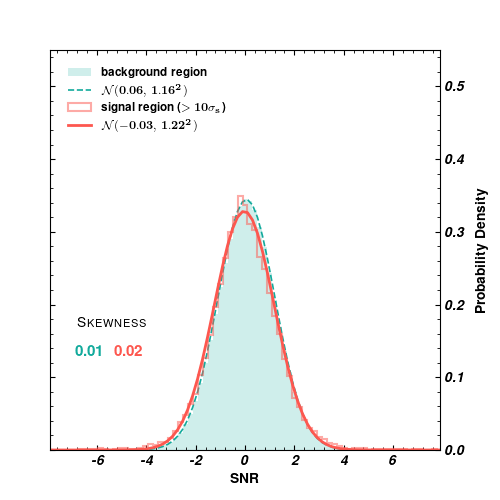

In [14]:
# Fig 2
# >>> make simple statistics over differential SNR <<< #

fig = plt.figure(figsize=(5, 5))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
fig.subplots_adjust(hspace=0.03, wspace=0.03, \
    left=0.1, right=0.88, bottom=0.1, top=0.9)

# draw histograms
ax = plt.subplot(111)
bins = np.linspace(-10., 10., 100)
ax.hist(DCDSNR_BKG[np.abs(DCDSNR_BKG) < 10.0], bins=bins, density=True, \
    color='#12aa9c', linewidth=1.3, label=r'\textbf{background region}', alpha=0.2, zorder=1) #00A5C9

ax.plot(bins, stats.norm.pdf(bins, DCDSNR_BKG_MEAN, DCDSNR_BKG_STD), \
    linestyle='--', color='#12aa9c', linewidth=1.2, label=r'${\bf \mathcal{N}(%.2f,\,%.2f^{2}})$' \
    %(DCDSNR_BKG_MEAN, DCDSNR_BKG_STD), alpha=1, zorder=1) #00A5C9

ax.hist(DCDSNR_DET[np.abs(DCDSNR_DET) < 10.0], bins=bins, density=True, \
    color='#FD574F', linewidth=1.5, histtype='step', \
    label=r'\textbf{signal region (${\bf > 10\sigma_s}$)}', alpha=0.5, zorder=2)

ax.plot(bins, stats.norm.pdf(bins, DCDSNR_DET_MEAN, DCDSNR_DET_STD), \
    linestyle='-', color='#FD574F', linewidth=2., label=r'${\bf \mathcal{N}(%.2f,\,%.2f^{2}})$' \
    %(DCDSNR_DET_MEAN, DCDSNR_DET_STD), zorder=2)

ax.annotate(r'\textsc{Skewness}', xy=(-6.8, 0.12+0.05), fontsize=10., color='black')
ax.annotate(r'\textbf{%.2f}' %DCDSNR_BKG_SKEW, xy=(-6.9, 0.08+0.05), fontsize=11., color='#12aa9c') #00A5C9
ax.annotate(r'\textbf{%.2f}' %DCDSNR_DET_SKEW, xy=(-5.3, 0.08+0.05), fontsize=11., color='#FD574F')

ax.legend(loc=2, frameon=False, fontsize=8.5, borderpad=1)
ax.tick_params(which='both', top=True, bottom=True, left=True, right=True, \
    labelleft=False, labelright=True, labelbottom=True, labeltop=False)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.4))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.02))

ax.xaxis.set_ticks(ax.get_xticks())
ax.set_xticklabels([r'\textit{\textbf{%d}}' %int(t) for t in ax.get_xticks()])
plt.setp(ax.get_xticklabels(), fontsize=10)

ax.yaxis.set_ticks(np.arange(0, 1., 0.1))
ax.set_yticklabels([r'\textit{\textbf{%.1f}}' %t for t in ax.get_yticks()])
plt.setp(ax.get_yticklabels(), fontsize=10)

ax.set_xlabel(r'\textbf{SNR}')
ax.set_ylabel(r'\textbf{Probability Density', labelpad=8)
ax.yaxis.set_label_position("right")
ax.set_xlim(-7.9, 7.9)
ax.set_ylim(0, 0.55)
plt.show()
